In [18]:
!pip install scikit-learn keras-tuner git+https://github.com/paulgavrikov/visualkeras.git
!python --version

  Cloning https://github.com/paulgavrikov/visualkeras.git to /tmp/pip-req-build-el290pm8
  Running command git clone --filter=blob:none --quiet https://github.com/paulgavrikov/visualkeras.git /tmp/pip-req-build-el290pm8
  Resolved https://github.com/paulgavrikov/visualkeras.git to commit cd169b81be347e2090353ad6fe2bd2e1f4020cf4
  Preparing metadata (setup.py) ... done

[notice] A new release of pip is available: 23.0.1 -> 23.1.2
[notice] To update, run: python3 -m pip install --upgrade pip
Python 3.8.10


In [31]:
import numpy as np
import matplotlib.pyplot as plt

import keras_tuner
import tensorflow as tf
import keras

from keras import layers
from keras.utils import timeseries_dataset_from_array, to_categorical
import visualkeras
from PIL import ImageFont
import logging
from enum import Enum
import itertools
import os
import pickle
import re
import random
import time

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import KFold
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
#from utils import load_gesture_samples, GestureNames, split_data_between_participants, normalize_dataset

In [2]:
print(tf.__version__)

print('1: ', tf.config.list_logical_devices())
print('2: ', tf.test.is_built_with_cuda())
print('3: ', tf.test.gpu_device_name())
print('4: ', tf.config.get_visible_devices())

print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

2.12.0
1:  [LogicalDevice(name='/device:CPU:0', device_type='CPU'), LogicalDevice(name='/device:GPU:0', device_type='GPU')]
2:  True
3:  /device:GPU:0
4:  [PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'), PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
Num GPUs Available:  1


2023-05-21 10:45:22.560820: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:982] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-05-21 10:45:22.576745: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:982] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-05-21 10:45:22.576927: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:982] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-05-21 10:45:22.579461: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:982] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-05-21 10:45:22.579572: I tensorflow/compile

In [3]:
# Setup logger
logging.basicConfig(level=logging.DEBUG,
                    force = True)

log = logging.getLogger("CSE3000")
log.setLevel(logging.INFO)

In [93]:
# Utility functions cell
RANDOM_SEED = 1000


np.random.seed(RANDOM_SEED)
tf.random.set_seed(RANDOM_SEED)


class Hand(Enum):
    right = "right_hand"
    left = "left_hand"


class GestureException(Exception):
    pass


class Gestures(Enum):
    SWIPE_LEFT = 0, 'swipe_left'
    SWIPE_RIGHT = 1, 'swipe_right'
    SWIPE_UP = 2, 'swipe_up'
    SWIPE_DOWN = 3, 'swipe_down'
    ROT_CW = 4, 'clockwise'
    ROT_CCW = 5, 'counter_clockwise'
    TAP = 6, 'tap'
    DOUBLE_TAP = 7, 'double_tap'
    ZOOM_IN = 8, 'zoom_in'
    ZOOM_OUT = 9, 'zoom_out'

    def __new__(cls, value, name):
        member = object.__new__(cls)
        member._value_ = value
        member.fullname = name
        return member

    def __int__(self):
        return self.value

    def __str__(self):
        return self.fullname

    @staticmethod
    def from_name(name: str):
        try:
            return next(g for g in Gestures if g.fullname == name)
        except StopIteration:
            raise GestureException("No gesture with name '%s' found..." % name)


class LoadGestureException(Exception):
    pass


def load_gesture_samples(gesture: Gestures, hand: Hand = Hand.right, skip_old_data: bool = True):
    result = []
    base_path = f"gestures_data/gestures/{gesture.fullname}/{hand.value}"
    log.debug("Loading gestures from base path: %s" % base_path)
    folder_items = os.listdir(base_path)

    # Filter on the .pickle extension
    filtered_ext = list(filter(lambda x: re.search(r'\.pickle$', x) is not None, folder_items))

    if len(filtered_ext) == 0:
        raise LoadGestureException("No gestures found in folder: %s" % base_path)

    for item in filtered_ext:
        r_match = re.match(r'candidate_(\w+).pickle$', item)
        if r_match is None:
            raise LoadGestureException("Incorrectly formatted data file name: %s" % item)

        candidate_id = r_match.group(1)
        with open(os.path.join(base_path, item), 'rb') as f:
            while True:
                try:
                    data_contents = pickle.load(f)

                    if isinstance(data_contents, dict):
                        if 'target_gesture' in data_contents:
                            # Data v3
                            # print(data_contents)
                            data_contents['gesture'] = Gestures.from_name(data_contents['target_gesture'])
                            # data_contents['all_data'] = data_contents['data']
                            # print(type(data_contents['data']))
                            # data_contents['data'] = list(map(lambda x: x['data'], data_contents['data']))
                            result.append(data_contents)
                        else:
                            # Data v2
                            data_contents['gesture'] = Gestures.from_name(data_contents['gesture'])
                            if not skip_old_data:
                                result.append(data_contents)
                    else:
                        # Data loader v1
                        data = {
                            'data': data_contents,
                            'gesture': gesture,
                            'candidate': candidate_id
                        }
                        if not skip_old_data:
                            result.append(data)
                except EOFError:
                    break

    return result


def split_data_between_participants(data, ratio = 0.7):
    lb_candidate = lambda x: x['candidate']

    # For itertools.groupby to work we need to sort the data first
    data.sort(key=lambda x: x['candidate'])

    participants = set(map(lb_candidate, data))
    amount_measurements = len(data)
    amount_participants = len(participants)

    log.debug("Participants: %s" % participants)
    log.info("Got dataset for %d participants with %d measurements total" % (amount_participants, amount_measurements))

    amount_train = int(amount_measurements * 0.7)
    amount_test = amount_measurements - amount_train
    log.info("Estimating %d measurements for training and %d measurements for test (ratio: %0.1f)" % (amount_train, amount_test, ratio))

    train_data = []
    train_data_outcomes = []

    test_data = []
    test_data_outcomes = []

    train_candidates = set()
    test_candidates = set()

    # Group the data per participant as that is the recommended method for training models
    for participant, d in itertools.groupby(data, lb_candidate):
        d_list = list(d)

        for data_point in d_list:
            if len(train_data) < amount_train:
                train_candidates.add(participant)
                train_data.append(data_point['data'])
                train_data_outcomes.append(data_point['gesture'])
            else:
                test_candidates.add(participant)
                test_data.append(data_point['data'])
                test_data_outcomes.append(data_point['gesture'])
                # test_data.extend([p['data'] for p in d_list])
                # test_data_outcomes.extend([p['gesture'].value for p in d_list])

    log.info("Train candidates: %s\tTest candidates: %s" % (train_candidates, test_candidates))

    return (np.array(train_data), np.array(train_data_outcomes)), (np.array(test_data), np.array(test_data_outcomes))

def normalize_dataset(data):
    """Watch out this function might not normalize the data as expected, further research required"""
    normalized = []
    for graph in data:
        scaler = MinMaxScaler(feature_range=(0, 1))
        reshaped = scaler.fit_transform(graph.reshape(-1, graph.shape[-1])).reshape(graph.shape)
        normalized.append(reshaped)
    return np.array(normalized)

def normalize_test(data):
    normalized = []
    for measurement in data:
        mean = measurement.mean()
        std = measurement.std()
        normalized_measurement = (measurement - mean) / std

        normalized.append(normalized_measurement)
    return normalized

def plot_history(history):
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    acc = history.history['acc']
    val_acc = history.history['val_acc']
    mae = history.history['mae']
    val_mae = history.history['val_mae']

    epochs = range(1, len(loss) + 1)

    fig, axs = plt.subplots(1, 3, figsize=(25, 5))

    axs[0].plot(epochs, loss, 'g.', label='Training Loss')
    axs[0].plot(epochs, val_loss, 'c.', label='Validation Loss')
    axs[0].set_xlabel('Epochs')
    axs[0].set_ylabel('Loss')
    axs[0].legend()

    axs[1].plot(epochs, mae, 'g.', label='Training MAE')
    axs[1].plot(epochs, val_mae, 'c.', label='Validation MAE')
    axs[1].set_xlabel('Epochs')
    axs[1].set_ylabel('MAE')
    axs[1].legend()

    axs[2].plot(epochs, acc, 'g.', label='Training Accuracy')
    axs[2].plot(epochs, val_acc, 'c.', label='Validation Accuracy')
    axs[2].set_xlabel('Epochs')
    axs[2].set_ylabel('Accuracy')
    axs[2].legend()

    fig.savefig('output_figures/history_plot.svg')
    fig.show()

def compile_model(model: keras.Model):
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['acc', 'mae'])

def kfold_cross_validation(model: keras.Model, features: np.ndarray, labels: np.ndarray, num_folds: int = 5):
    kfold = KFold(num_folds, shuffle=True, random_state=RANDOM_SEED)

    fold_num = 1
    acc_per_fold = []
    loss_per_fold = []
    confusion_per_fold = []

    for train, test in kfold.split(features, labels):
        fold_model = keras.models.clone_model(model)
        log.info("Fold No. %d" % fold_num)
        compile_model(fold_model)
        history = fold_model.fit(features[train], labels[train], batch_size=32, epochs=200, verbose=2)
        scores = fold_model.evaluate(features[test], labels[test], verbose=2)
        predictions = np.argmax(fold_model.predict(features[test]), axis=1)
        acc_per_fold.append(scores[1] * 100)
        loss_per_fold.append(scores[0])
        # confusion_per_fold.append(confusion_matrix(labels[test], predictions))

        fold_num += 1



    return acc_per_fold, loss_per_fold, confusion_per_fold


In [91]:
combined = []

# skip_gestures = [Gestures.ZOOM_IN, Gestures.ZOOM_OUT, Gestures.DOUBLE_TAP, Gestures.ROT_CW, Gestures.ROT_CCW]
skip_gestures = []
# only_gestures = [Gestures.SWIPE_UP, Gestures.SWIPE_DOWN, Gestures.SWIPE_RIGHT, Gestures.SWIPE_LEFT, Gestures.TAP]
filtered_gestures = filter(lambda x: x not in skip_gestures, Gestures)
filtered_gestures_list = list(filtered_gestures)

right_samples_count = 0
left_samples_count = 0
for g in filtered_gestures_list:
    right_samples = load_gesture_samples(g, hand=Hand.right)
    left_samples = load_gesture_samples(g, hand=Hand.left)
    right_samples_count += len(right_samples)
    left_samples_count += len(left_samples)
    combined.extend(right_samples)
    combined.extend(left_samples)

log.info("Got %d Right hand measurements and %d Left hand measurements" % (right_samples_count, left_samples_count))

# Deterministic shuffle
random.Random(4).shuffle(combined)
(x_train, y_train), (x_test, y_test) = split_data_between_participants(combined)

print(x_train.shape)
print(y_train.shape)

print(x_test.shape)
print(y_test.shape)

x_train_normalized = normalize_dataset(x_train)
x_test_normalized = normalize_dataset(x_test)

y_train = to_categorical(y_train, len(Gestures))
y_test = to_categorical(y_test, len(Gestures))

# Hardcoded for now, so fix
# x_train_normalized = x_train_normalized.reshape((-1, 100, 3, 1))
# x_test_normalized = x_test_normalized.reshape((-1, 100, 3, 1))

# For CNN
input_shape = (25, 4, 3)
x_train_reshaped = x_train_normalized.reshape((-1, 25, 4, 3))
x_test_reshaped = x_test_normalized.reshape((-1, 25, 4, 3))

print(x_train_normalized.shape)
print(x_test_normalized.shape)

# Combine for K-Fold
combined_x = np.concatenate([x_train_normalized, x_test_normalized])
combined_y = np.concatenate([y_train, y_test])

print(combined_x.shape)
print(combined_y.shape)


INFO:CSE3000:Got 478 Right hand measurements and 262 Left hand measurements
INFO:CSE3000:Got dataset for 11 participants with 740 measurements total
INFO:CSE3000:Estimating 518 measurements for training and 222 measurements for test (ratio: 0.7)
INFO:CSE3000:Train candidates: {'C2', 'E1', 'A1', 'Arne', 'E3', 'E0', 'C3', 'C1', 'E2'}	Test candidates: {'E4', 'E3', 'sem_15052023'}


(518, 100, 3)
(518,)
(222, 100, 3)
(222,)
(518, 100, 3)
(222, 100, 3)
(740, 100, 3)
(740, 10)


ValueError: x and y can be no greater than 2D, but have shapes (10,) and (10, 10, 3)

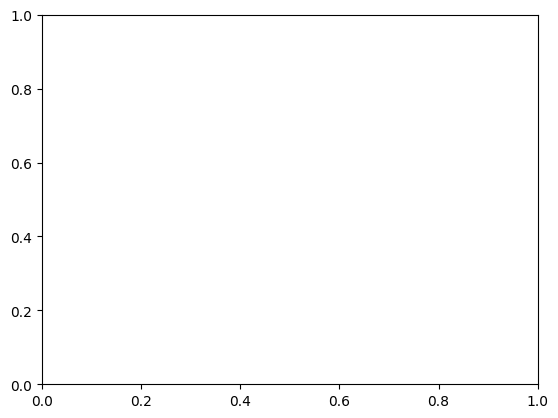

In [151]:
# Visualisation for CNN
one_sample = x_train_normalized[200]
plt.plot(one_sample)
plt.savefig('output_figures/sample_graph.svg')
plt.show()

(10, 10, 3)
(10, 10, 3)


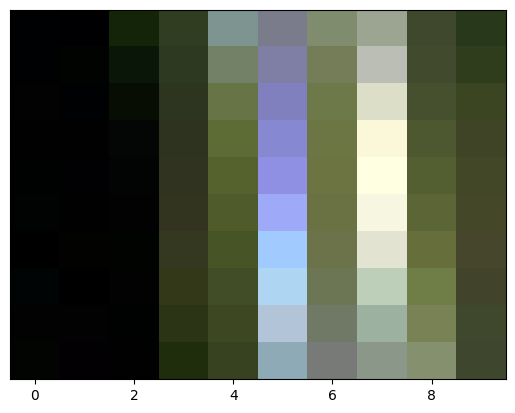

In [217]:
# reshaped_sample = one_sample.reshape((100, 3))
reshaped_sample = np.rot90(one_sample, k=1)
print(one_sample.shape)
print(reshaped_sample.shape)
# plt.plot(one_sample[:,0])
plt.imshow(1 - reshaped_sample, cmap='Greys', interpolation='nearest', aspect='auto')
plt.yticks([])
plt.savefig('output_figures/sample_heatmap.svg')
plt.show()

(4, 25, 1)


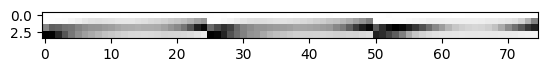

In [223]:
print(x_train_normalized[0][:,:,:1].shape)
one_sample = x_train_normalized[200]
image_data = np.concatenate([one_sample[:,:,0], one_sample[:,:,1], one_sample[:,:,2]], axis=1)
plt.imshow(1-image_data, cmap='Greys', aspect=1)
plt.savefig('output_figures/convolutional_sample.svg')
plt.show()

In [ ]:
# Show all training data
train_amount = len(x_train)
fig, axs = plt.subplots(1, train_amount, figsize=(40, 4))
for i in range(train_amount):
    axs[i].plot(x_train[i])
    axs[i].annotate(Gestures(y_train[i]).fullname, (0,0), (0, -40), xycoords='axes fraction', textcoords='offset points', va='top')

In [ ]:
# Show all test data
test_amount = len(x_test)
fig, axs = plt.subplots(1, test_amount, figsize=(20, 4))
for i in range(test_amount):
    axs[i].plot(x_test[i])
    axs[i].annotate(f'Gesture: {Gestures(y_test[i]).fullname}', (0,0), (0, -40), xycoords='axes fraction', textcoords='offset points', va='top')

In [ ]:
# Show normalized test data
test_amount = len(x_test_normalized)
fig, axs = plt.subplots(1, test_amount, figsize=(20, 4))
for i in range(test_amount):
    axs[i].plot(x_test_normalized[i])

In [ ]:
# Implement data windowing
# SLICES = 5
#
# single_source = np.array(train[0], dtype=np.uint16)
# single_targets = np.full((single_source.shape[0], 1, 1), train_outcome[0])
# print(single_source.shape)
#
# train_ds = timeseries_dataset_from_array(data=single_source, targets=single_targets, sequence_length=SLICES, sequence_stride=SLICES)
#
# for example_inputs, example_labels in train_ds.take(1):
#     print(f'Inputs shape (batch, time, features): {example_inputs.shape}')
#     print(f'Targets shape (batch, time, features): {example_labels.shape}')
#
#
# single_validation_source = np.array(test[0], dtype=np.uint16)
# single_validation_targets = np.full((single_validation_source.shape[0], 1, 1), test_outcome[0])
#
# validation_ds = keras.utils.timeseries_dataset_from_array(data=single_validation_source, targets=single_validation_targets, sequence_length=SLICES, sequence_stride=SLICES)


In [ ]:
# train_ds = timeseries_dataset_from_array(data=x_train, targets=y_train, sequence_length=SLICES, sequence_stride=SLICES)
# validation_ds = timeseries_dataset_from_array(data=x_test, targets=y_test, sequence_length=SLICES, sequence_stride=SLICES)

In [ ]:
# print(dir(train_ds))
# print(train_ds.element_spec)

In [69]:
USE_GPU = False
device = "/device:GPU:0" if USE_GPU else "/device:CPU:0"

def build_cnn_model(shape):
    model = keras.Sequential()

    # model_lstm.add(layers.LSTM(units=128, input_shape=[1, 3]))
    model.add(layers.Input(shape=shape, name="sensor_image"))
    model.add(layers.ZeroPadding2D(padding=(0, 2)))
    model.add(layers.Conv2D(8, kernel_size=(3, 3), strides=(1, 1), activation="relu"))
    model.add(layers.Conv2D(16, kernel_size=(2, 2), strides=(1, 1), activation="relu"))
    model.add(layers.Conv2D(16, kernel_size=(2, 2), activation="relu"))
    model.add(layers.MaxPooling2D(pool_size=(3, 1)))
    model.add(layers.Conv2D(32, kernel_size=(5, 1), activation="relu"))
    model.add(layers.Flatten())
    model.add(layers.Dropout(0.5))
    model.add(layers.Dense(len(Gestures), activation="softmax", name="predictions"))

    return model


In [78]:
model_cnn = build_cnn_model(input_shape)
model_cnn.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['acc', 'mae'])
model_cnn.summary()
start = time.perf_counter()
simple_history = model_cnn.fit(x_train_reshaped, y_train, epochs=200, batch_size=2, validation_data=(x_test_reshaped, y_test))

end = time.perf_counter()
print("Training took: %0.1f seconds" % (end - start))

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 zero_padding2d_1 (ZeroPaddi  (None, 25, 8, 3)         0         
 ng2D)                                                           
                                                                 
 conv2d_4 (Conv2D)           (None, 23, 6, 8)          224       
                                                                 
 conv2d_5 (Conv2D)           (None, 22, 5, 16)         528       
                                                                 
 conv2d_6 (Conv2D)           (None, 21, 4, 16)         1040      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 7, 4, 16)         0         
 2D)                                                             
                                                                 
 conv2d_7 (Conv2D)           (None, 3, 4, 32)         

KeyboardInterrupt: 

# Training times:
| GPU   | CPU   |
|-------|-------|
| 18.5s | 12.3s |

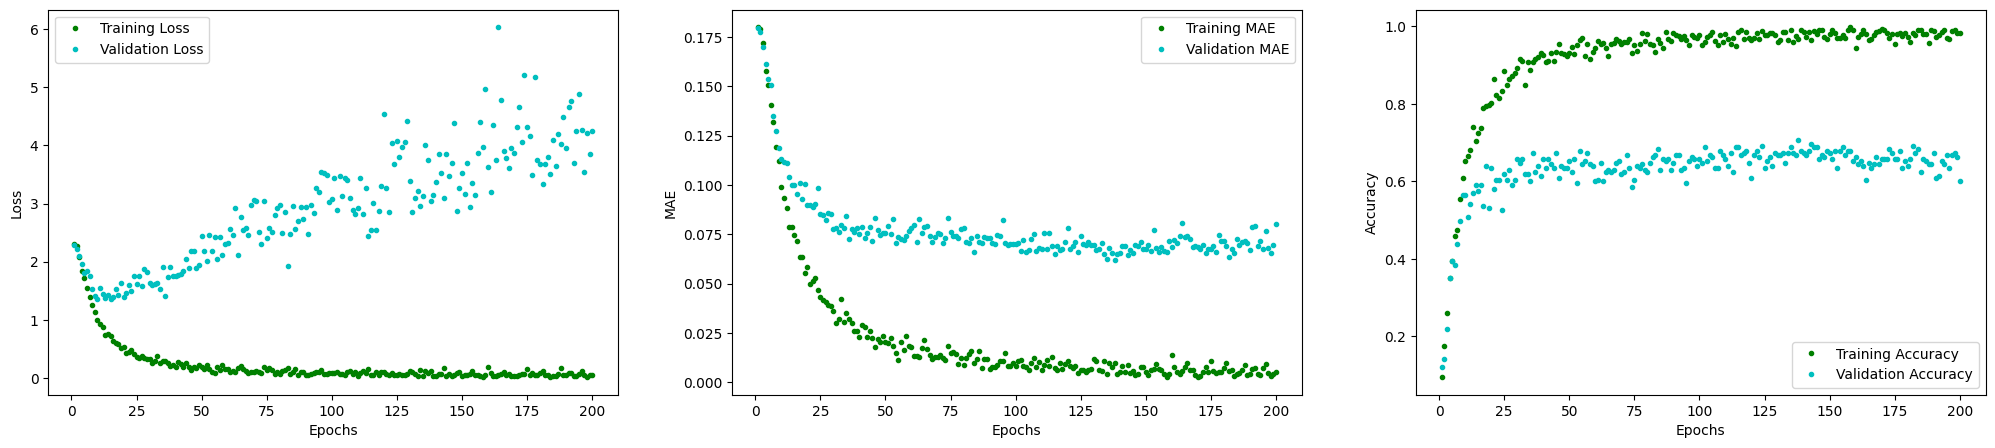

In [71]:
plot_history(simple_history)

In [236]:
score = model_cnn.evaluate(x_test_normalized, y_test, verbose=0)
print("Test loss:", score[0])
print("Test accuracy:", score[1])

Test loss: 2.2830429077148438
Test accuracy: 0.6926829218864441


7/7 [==============================] - 0s 2ms/step


DEBUG:matplotlib.colorbar:locator: <matplotlib.ticker.AutoLocator object at 0x7faae47bad90>


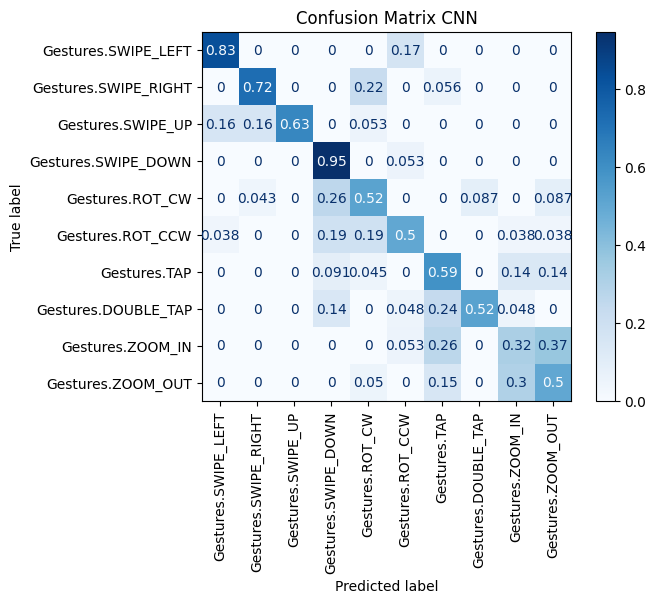

In [77]:
y_pred = model_cnn.predict(x_test_reshaped)
ConfusionMatrixDisplay.from_predictions(np.argmax(y_test, axis=1), np.argmax(y_pred, axis=1), normalize='true', cmap='Blues', display_labels=Gestures, xticks_rotation='vertical')

plt.title("Confusion Matrix CNN")
plt.savefig('output_figures/confusion_matrix_cnn.svg', bbox_inches="tight")

plt.show()

In [17]:
# K-Fold validation
model_cnn = build_cnn_model(input_shape)
(acc_per_fold, loss_per_fold, confusion_per_fold) = kfold_cross_validation(model_cnn, combined_x, combined_y, num_folds=5)

INFO:CSE3000:Fold No. 1


Epoch 1/200
17/17 - 1s - loss: 2.3023 - acc: 0.0938 - mae: 0.1799 - 1s/epoch - 78ms/step
Epoch 2/200
17/17 - 0s - loss: 2.2928 - acc: 0.1526 - mae: 0.1798 - 43ms/epoch - 3ms/step
Epoch 3/200
17/17 - 0s - loss: 2.2779 - acc: 0.1636 - mae: 0.1794 - 41ms/epoch - 2ms/step
Epoch 4/200
17/17 - 0s - loss: 2.2602 - acc: 0.1507 - mae: 0.1789 - 47ms/epoch - 3ms/step
Epoch 5/200
17/17 - 0s - loss: 2.2198 - acc: 0.2077 - mae: 0.1779 - 43ms/epoch - 3ms/step
Epoch 6/200
17/17 - 0s - loss: 2.1529 - acc: 0.2335 - mae: 0.1756 - 47ms/epoch - 3ms/step
Epoch 7/200
17/17 - 0s - loss: 2.0915 - acc: 0.2482 - mae: 0.1729 - 46ms/epoch - 3ms/step
Epoch 8/200
17/17 - 0s - loss: 2.0270 - acc: 0.2904 - mae: 0.1693 - 47ms/epoch - 3ms/step
Epoch 9/200
17/17 - 0s - loss: 1.9104 - acc: 0.3438 - mae: 0.1635 - 43ms/epoch - 3ms/step
Epoch 10/200
17/17 - 0s - loss: 1.8526 - acc: 0.3658 - mae: 0.1596 - 41ms/epoch - 2ms/step
Epoch 11/200
17/17 - 0s - loss: 1.8521 - acc: 0.3915 - mae: 0.1591 - 50ms/epoch - 3ms/step
Epoch 12/

INFO:CSE3000:Fold No. 2


Epoch 1/200
17/17 - 1s - loss: 2.3025 - acc: 0.1213 - mae: 0.1799 - 1s/epoch - 60ms/step
Epoch 2/200
17/17 - 0s - loss: 2.2937 - acc: 0.1103 - mae: 0.1798 - 68ms/epoch - 4ms/step
Epoch 3/200
17/17 - 0s - loss: 2.2842 - acc: 0.1379 - mae: 0.1795 - 66ms/epoch - 4ms/step
Epoch 4/200
17/17 - 0s - loss: 2.2770 - acc: 0.1526 - mae: 0.1793 - 62ms/epoch - 4ms/step
Epoch 5/200
17/17 - 0s - loss: 2.2550 - acc: 0.1526 - mae: 0.1787 - 65ms/epoch - 4ms/step
Epoch 6/200
17/17 - 0s - loss: 2.2240 - acc: 0.1728 - mae: 0.1779 - 70ms/epoch - 4ms/step
Epoch 7/200
17/17 - 0s - loss: 2.2041 - acc: 0.1838 - mae: 0.1768 - 62ms/epoch - 4ms/step
Epoch 8/200
17/17 - 0s - loss: 2.1339 - acc: 0.2629 - mae: 0.1748 - 62ms/epoch - 4ms/step
Epoch 9/200
17/17 - 0s - loss: 2.0693 - acc: 0.2629 - mae: 0.1717 - 55ms/epoch - 3ms/step
Epoch 10/200
17/17 - 0s - loss: 2.0278 - acc: 0.2647 - mae: 0.1697 - 61ms/epoch - 4ms/step
Epoch 11/200
17/17 - 0s - loss: 1.9501 - acc: 0.3051 - mae: 0.1660 - 55ms/epoch - 3ms/step
Epoch 12/

INFO:CSE3000:Fold No. 3


Epoch 1/200
17/17 - 1s - loss: 2.2984 - acc: 0.1195 - mae: 0.1799 - 934ms/epoch - 55ms/step
Epoch 2/200
17/17 - 0s - loss: 2.2884 - acc: 0.1213 - mae: 0.1796 - 63ms/epoch - 4ms/step
Epoch 3/200
17/17 - 0s - loss: 2.2737 - acc: 0.1324 - mae: 0.1793 - 66ms/epoch - 4ms/step
Epoch 4/200
17/17 - 0s - loss: 2.2510 - acc: 0.1562 - mae: 0.1785 - 69ms/epoch - 4ms/step
Epoch 5/200
17/17 - 0s - loss: 2.2045 - acc: 0.1801 - mae: 0.1769 - 72ms/epoch - 4ms/step
Epoch 6/200
17/17 - 0s - loss: 2.1655 - acc: 0.2077 - mae: 0.1755 - 67ms/epoch - 4ms/step
Epoch 7/200
17/17 - 0s - loss: 2.0934 - acc: 0.2408 - mae: 0.1722 - 66ms/epoch - 4ms/step
Epoch 8/200
17/17 - 0s - loss: 2.0129 - acc: 0.2721 - mae: 0.1683 - 66ms/epoch - 4ms/step
Epoch 9/200
17/17 - 0s - loss: 1.9461 - acc: 0.2886 - mae: 0.1649 - 59ms/epoch - 3ms/step
Epoch 10/200
17/17 - 0s - loss: 1.9324 - acc: 0.3015 - mae: 0.1633 - 65ms/epoch - 4ms/step
Epoch 11/200
17/17 - 0s - loss: 1.8790 - acc: 0.3309 - mae: 0.1600 - 61ms/epoch - 4ms/step
Epoch 

INFO:CSE3000:Fold No. 4


Epoch 1/200
17/17 - 1s - loss: 2.3175 - acc: 0.0882 - mae: 0.1800 - 1s/epoch - 62ms/step
Epoch 2/200
17/17 - 0s - loss: 2.2975 - acc: 0.0846 - mae: 0.1799 - 73ms/epoch - 4ms/step
Epoch 3/200
17/17 - 0s - loss: 2.2966 - acc: 0.1250 - mae: 0.1798 - 67ms/epoch - 4ms/step
Epoch 4/200
17/17 - 0s - loss: 2.2768 - acc: 0.1324 - mae: 0.1794 - 70ms/epoch - 4ms/step
Epoch 5/200
17/17 - 0s - loss: 2.2713 - acc: 0.1434 - mae: 0.1792 - 70ms/epoch - 4ms/step
Epoch 6/200
17/17 - 0s - loss: 2.2420 - acc: 0.1562 - mae: 0.1785 - 70ms/epoch - 4ms/step
Epoch 7/200
17/17 - 0s - loss: 2.2055 - acc: 0.1875 - mae: 0.1774 - 72ms/epoch - 4ms/step
Epoch 8/200
17/17 - 0s - loss: 2.1355 - acc: 0.2390 - mae: 0.1752 - 69ms/epoch - 4ms/step
Epoch 9/200
17/17 - 0s - loss: 2.0905 - acc: 0.2353 - mae: 0.1731 - 70ms/epoch - 4ms/step
Epoch 10/200
17/17 - 0s - loss: 1.9964 - acc: 0.2923 - mae: 0.1699 - 72ms/epoch - 4ms/step
Epoch 11/200
17/17 - 0s - loss: 1.9333 - acc: 0.3217 - mae: 0.1665 - 66ms/epoch - 4ms/step
Epoch 12/

INFO:CSE3000:Fold No. 5


Epoch 1/200
17/17 - 1s - loss: 2.3001 - acc: 0.1085 - mae: 0.1799 - 927ms/epoch - 55ms/step
Epoch 2/200
17/17 - 0s - loss: 2.2933 - acc: 0.1324 - mae: 0.1798 - 66ms/epoch - 4ms/step
Epoch 3/200
17/17 - 0s - loss: 2.2780 - acc: 0.1599 - mae: 0.1794 - 71ms/epoch - 4ms/step
Epoch 4/200
17/17 - 0s - loss: 2.2508 - acc: 0.1562 - mae: 0.1785 - 70ms/epoch - 4ms/step
Epoch 5/200
17/17 - 0s - loss: 2.2117 - acc: 0.2040 - mae: 0.1772 - 67ms/epoch - 4ms/step
Epoch 6/200
17/17 - 0s - loss: 2.1662 - acc: 0.2059 - mae: 0.1754 - 69ms/epoch - 4ms/step
Epoch 7/200
17/17 - 0s - loss: 2.1152 - acc: 0.2445 - mae: 0.1729 - 70ms/epoch - 4ms/step
Epoch 8/200
17/17 - 0s - loss: 2.0493 - acc: 0.2868 - mae: 0.1698 - 64ms/epoch - 4ms/step
Epoch 9/200
17/17 - 0s - loss: 2.0110 - acc: 0.2629 - mae: 0.1678 - 66ms/epoch - 4ms/step
Epoch 10/200
17/17 - 0s - loss: 1.9098 - acc: 0.3235 - mae: 0.1626 - 65ms/epoch - 4ms/step
Epoch 11/200
17/17 - 0s - loss: 1.8680 - acc: 0.3456 - mae: 0.1599 - 61ms/epoch - 4ms/step
Epoch 

In [18]:
print(acc_per_fold)
print(loss_per_fold)
print("Acc: %.3f std: %.3f" % (np.average(acc_per_fold), np.std(acc_per_fold)))
print(np.average(loss_per_fold))

[71.32353186607361, 81.61764740943909, 74.26470518112183, 84.5588207244873, 75.73529481887817]
[1.1708455085754395, 0.7949061989784241, 0.8225334286689758, 0.656621515750885, 1.2283391952514648]
Acc: 77.500 std: 4.869
0.9346491694450378


In [ ]:
print(x_test_normalized.shape)

for i in range(x_test_normalized.shape[0]):
    test_sample = np.expand_dims(x_test_normalized[i], -4)
    test_prediction = model_cnn.predict(test_sample)
    print("Prediction: %s, actual: %s" % (Gestures(np.argmax(test_prediction)), Gestures(np.argmax(y_test[i]))))

(475, 100, 3)
(100, 3)
(10,)
(10, 4, 3)
(10,)
Input length is: 10


2023-05-19 12:46:21.591928: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_28' with dtype int32 and shape [10]
	 [[{{node Placeholder/_28}}]]
2023-05-19 12:46:21.592221: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_20' with dtype float and shape [10]
	 [[{{node Placeholder/_20}}]]


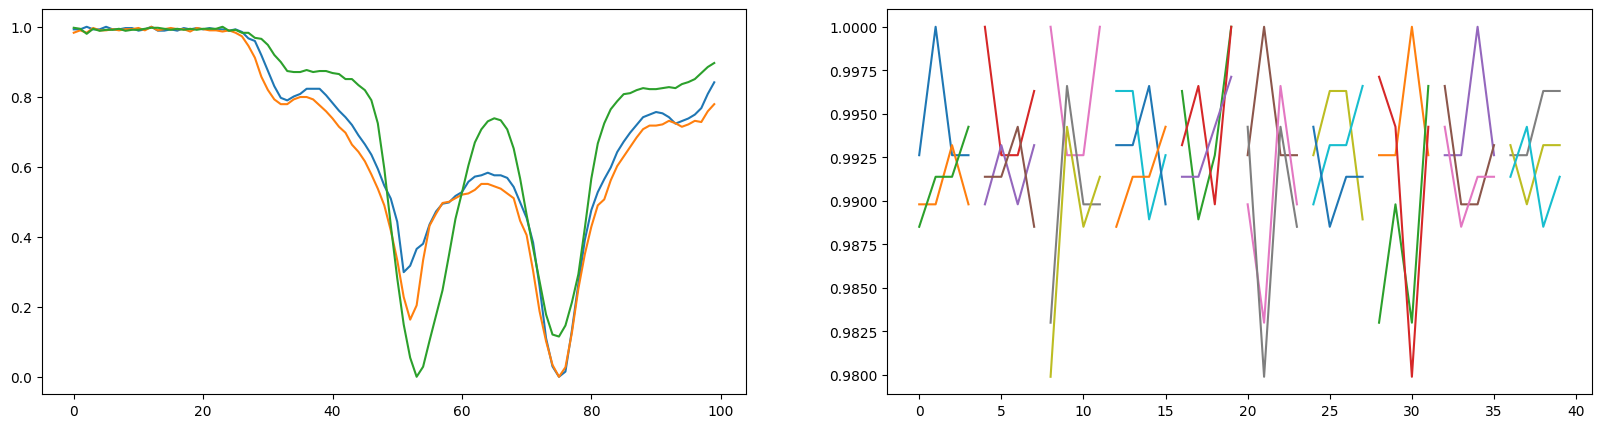

In [355]:
# Split data visualisation
print(x_train_normalized.shape)
SEQUENCE_LENGTH = 4

for measurement_x, measurement_y in zip(x_train_normalized, y_train):

    # Lock the measurement for now:
    measurement_x = x_train_normalized[200]
    measurement_y = y_train[200]
    print(measurement_x.shape)
    print(measurement_y.shape)
    fig, axs = plt.subplots(1, 2, figsize=(20, 5))
    axs[0].plot(measurement_x)
    timeseries_train_ds = timeseries_dataset_from_array(measurement_x, measurement_y, sequence_length=SEQUENCE_LENGTH, shuffle=True)

    for inputs, targets in timeseries_train_ds:
        print(inputs.shape)
        print(targets.shape)

        print("Input length is: %d" % len(inputs))
        for i in range(len(inputs)):
            axs[1].plot(np.arange(SEQUENCE_LENGTH * i, SEQUENCE_LENGTH * (i + 1)), inputs[i])
            # axs[1].plot(inputs[i])
            # plt.plot(np.arange(10 * i, 10 * (i + 1)), np.arange(1, step=0.1))


    fig.show()
    break

(10, 10, 3)


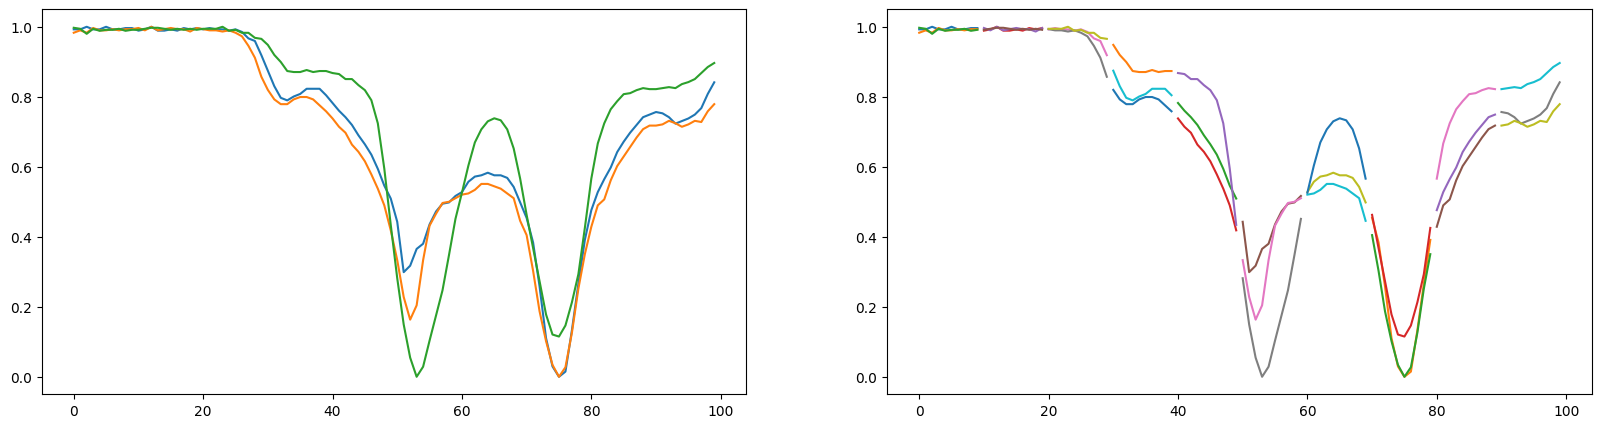

In [397]:
BATCH_SIZE = 10
SEQUENCE_LENGTH = 100

# Split video input visualisation
measurement_x = x_train_normalized[200]
measurement_y = y_train[200]

fig, axs = plt.subplots(1, 2, figsize=(20, 5))
axs[0].plot(measurement_x)

split_x = np.array(np.array_split(measurement_x, BATCH_SIZE))
for i in range(len(split_x)):
    axs[1].plot(np.arange((SEQUENCE_LENGTH/BATCH_SIZE) * i, (SEQUENCE_LENGTH/BATCH_SIZE) * (i + 1)), split_x[i])

print(split_x.shape)
fig.show()

In [24]:
USE_GPU = False
device = "/device:GPU:0" if USE_GPU else "/device:CPU:0"

def build_lstm_stateless_model(lstm_units, dense_1_units, dropout):
    # https://towardsdatascience.com/time-series-classification-for-human-activity-recognition-with-lstms-using-tensorflow-2-and-keras-b816431afdff
    model = keras.Sequential(name="LSTM_Stateless")

    # Subject to change as we split up the data in fragments:
    # Stateless?
    model.add(layers.Input(shape=(100, 3), name="sensor_image"))
    model.add(layers.LSTM(units=lstm_units, name="lstm"))
    # Stateful?
    # model_lstm_stateless.add(layers.Input(batch_shape=(100, 3, 1), name="sensor_image"))
    # model_lstm_stateless.add(layers.LSTM(units=128, stateful=True, name="lstm"))

    # Extra
    if dropout:
        model.add(layers.Dropout(rate=0.25, name="dropout"))

    model.add(layers.Dense(units=dense_1_units, activation='relu', name="dense_1"))

    # Output stage
    model.add(layers.Dense(len(Gestures), activation="softmax", name="predictions"))
    # model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['acc', 'mae'])
    model.summary()
    return model

def build_tuning_lstm_stateless_model(hp):
    lstm_units = hp.Choice('units', [32, 64, 128, 256, 512, 1024])
    dense_1_units = hp.Choice('units', [16, 32, 64, 128, 256, 512, 1024])
    dropout = hp.Boolean("dropout")
    model = build_lstm_stateless_model(lstm_units, dense_1_units, dropout)
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['acc', 'mae'])
    return model


In [377]:
with tf.device(device):
    start = time.perf_counter()
    tuner = keras_tuner.RandomSearch(build_tuning_lstm_stateless_model, objective='val_loss', max_trials=20)
    tuner.search(x_train_normalized, y_train, epochs=300, batch_size=16, shuffle=False, validation_data=(x_test_normalized, y_test))

    end = time.perf_counter()
    print("Tuning took %0.1f seconds" % (end - start))


INFO:tensorflow:Reloading Tuner from ./untitled_project/tuner0.json


INFO:tensorflow:Reloading Tuner from ./untitled_project/tuner0.json


INFO:tensorflow:Oracle triggered exit


INFO:tensorflow:Oracle triggered exit


Tuning took 0.0 seconds


In [ ]:
tuner.get_best_models()[0]

In [25]:
USE_GPU = True
device = "/device:GPU:0" if USE_GPU else "/device:CPU:0"

with tf.device(device):
    start = time.perf_counter()
    # Do we need to reset the states inbetween?

    model_lstm_stateless = build_lstm_stateless_model(128, 256, True)
    model_lstm_stateless.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['acc', 'mae'])

    lstm_stateless_history = model_lstm_stateless.fit(x_train_normalized, y_train, epochs=300, batch_size=16, shuffle=False, validation_data=(x_test_normalized, y_test))

    end = time.perf_counter()
    print("Training took %0.1f seconds" % (end - start))


Model: "LSTM_Stateless"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 128)               67584     
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 256)               33024     
                                                                 
 predictions (Dense)         (None, 10)                2570      
                                                                 
Total params: 103,178
Trainable params: 103,178
Non-trainable params: 0
_________________________________________________________________
Epoch 1/300


2023-05-21 10:56:43.861879: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-05-21 10:56:43.863404: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-05-21 10:56:43.864565: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

33/33 [==============================] - 2s 23ms/step - loss: 2.3004 - acc: 0.1081 - mae: 0.1799 - val_loss: 2.2770 - val_acc: 0.2252 - val_mae: 0.1794
Epoch 2/300
 1/33 [..............................] - ETA: 0s - loss: 2.1973 - acc: 0.3125 - mae: 0.1777

2023-05-21 10:56:45.748005: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-05-21 10:56:45.749203: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-05-21 10:56:45.750075: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

33/33 [==============================] - 0s 12ms/step - loss: 2.2514 - acc: 0.1776 - mae: 0.1781 - val_loss: 2.2461 - val_acc: 0.1396 - val_mae: 0.1783
Epoch 3/300
33/33 [==============================] - 0s 11ms/step - loss: 2.2191 - acc: 0.1911 - mae: 0.1765 - val_loss: 2.1642 - val_acc: 0.2252 - val_mae: 0.1763
Epoch 4/300
33/33 [==============================] - 0s 11ms/step - loss: 2.1319 - acc: 0.2162 - mae: 0.1741 - val_loss: 2.0899 - val_acc: 0.2883 - val_mae: 0.1731
Epoch 5/300
33/33 [==============================] - 0s 11ms/step - loss: 2.0875 - acc: 0.2239 - mae: 0.1709 - val_loss: 2.1125 - val_acc: 0.2252 - val_mae: 0.1745
Epoch 6/300
33/33 [==============================] - 0s 11ms/step - loss: 2.0638 - acc: 0.2896 - mae: 0.1703 - val_loss: 1.9712 - val_acc: 0.2568 - val_mae: 0.1679
Epoch 7/300
33/33 [==============================] - 0s 12ms/step - loss: 1.9819 - acc: 0.3012 - mae: 0.1644 - val_loss: 1.9130 - val_acc: 0.2523 - val_mae: 0.1651
Epoch 8/300
33/33 [=========

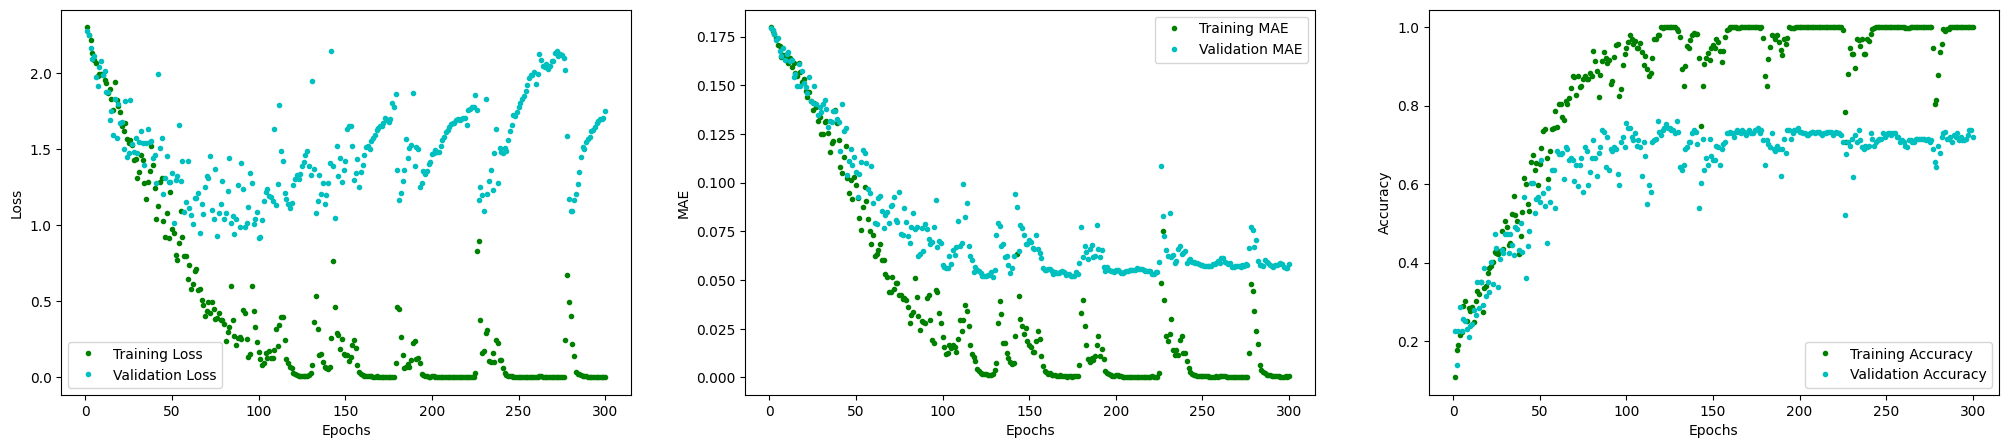

In [26]:
plot_history(lstm_stateless_history)

In [64]:
score = model_lstm_stateless.evaluate(x_test_normalized, y_test, verbose=0)
print("Test loss:", score[0])
print("Test accuracy:", score[1])

Test loss: 1.7495518922805786
Test accuracy: 0.7207207083702087


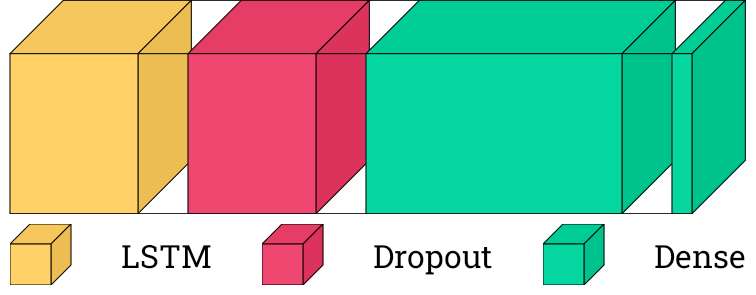

In [63]:
font = ImageFont.truetype("RobotoSlab-VariableFont_wght.ttf", 32)
visualkeras.layered_view(model_lstm_stateless, font=font, min_xy=160, scale_z=1, spacing=50, legend=True, to_file='output_figures/visual_lstm_stateless.png').show()

7/7 [==============================] - 0s 9ms/step


2023-05-21 11:13:45.807197: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-05-21 11:13:45.808637: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-05-21 11:13:45.809500: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

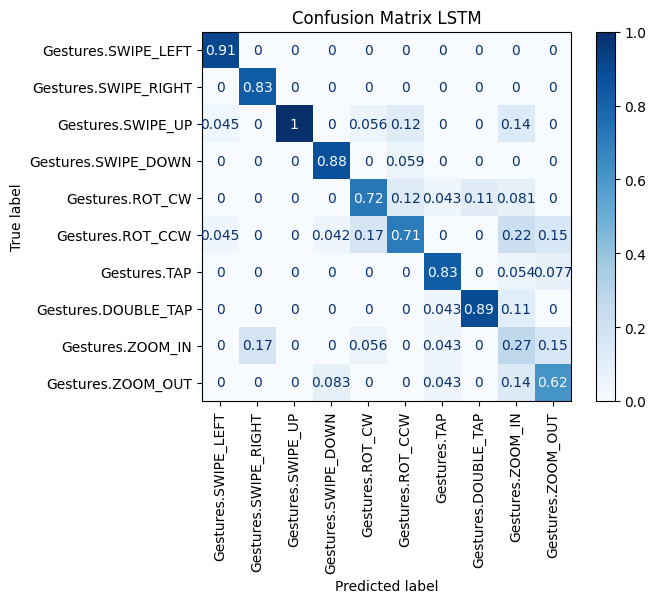

In [65]:
y_pred = model_lstm_stateless.predict(x_test_normalized)
ConfusionMatrixDisplay.from_predictions(np.argmax(y_test, axis=1), np.argmax(y_pred, axis=1), normalize='pred', cmap='Blues', display_labels=Gestures, xticks_rotation='vertical')

plt.title("Confusion Matrix LSTM")
plt.savefig('output_figures/confusion_matrix_lstm.svg', bbox_inches="tight")

plt.show()

In [ ]:
print("================= Running on training data (Toy Example): =================")
for i in range(x_train_normalized.shape[0]):
    test_sample = np.expand_dims(x_train_normalized[i], -4)
    test_prediction = model_lstm_stateless.predict(test_sample)
    print("Prediction: %s, actual: %s" % (Gestures(np.argmax(test_prediction)), Gestures(np.argmax(y_train[i]))))

print("\n\n================= Running on testing data: =================")
for i in range(x_test_normalized.shape[0]):
    test_sample = np.expand_dims(x_test_normalized[i], -4)
    test_prediction = model_lstm_stateless.predict(test_sample)
    print("Prediction: %s, actual: %s" % (Gestures(np.argmax(test_prediction)), Gestures(np.argmax(y_test[i]))))

In [89]:
# K-Fold validation
model = build_lstm_stateless_model(128, 256, True)
(acc_per_fold, loss_per_fold, confusion_per_fold) = kfold_cross_validation(model, combined_x, combined_y, num_folds=10)

Model: "LSTM_Stateless"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 128)               67584     
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 256)               33024     
                                                                 
 predictions (Dense)         (None, 10)                2570      
                                                                 
Total params: 103,178
Trainable params: 103,178
Non-trainable params: 0
_________________________________________________________________


2023-05-21 12:18:19.124276: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-05-21 12:18:19.125345: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-05-21 12:18:19.126065: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

Epoch 1/200


2023-05-21 12:18:19.411701: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-05-21 12:18:19.413120: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-05-21 12:18:19.414098: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

21/21 - 1s - loss: 2.3076 - acc: 0.0826 - mae: 0.1799 - 1s/epoch - 66ms/step
Epoch 2/200
21/21 - 0s - loss: 2.2703 - acc: 0.1817 - mae: 0.1787 - 178ms/epoch - 8ms/step
Epoch 3/200
21/21 - 0s - loss: 2.1996 - acc: 0.1922 - mae: 0.1765 - 185ms/epoch - 9ms/step
Epoch 4/200
21/21 - 0s - loss: 2.1346 - acc: 0.2072 - mae: 0.1732 - 177ms/epoch - 8ms/step
Epoch 5/200
21/21 - 0s - loss: 2.0893 - acc: 0.2207 - mae: 0.1707 - 170ms/epoch - 8ms/step
Epoch 6/200
21/21 - 0s - loss: 2.1141 - acc: 0.2342 - mae: 0.1735 - 171ms/epoch - 8ms/step
Epoch 7/200
21/21 - 0s - loss: 2.0095 - acc: 0.2523 - mae: 0.1677 - 169ms/epoch - 8ms/step
Epoch 8/200
21/21 - 0s - loss: 2.0089 - acc: 0.2523 - mae: 0.1684 - 164ms/epoch - 8ms/step
Epoch 9/200
21/21 - 0s - loss: 1.9907 - acc: 0.2523 - mae: 0.1671 - 173ms/epoch - 8ms/step
Epoch 10/200
21/21 - 0s - loss: 1.9059 - acc: 0.2928 - mae: 0.1624 - 167ms/epoch - 8ms/step
Epoch 11/200
21/21 - 0s - loss: 1.8677 - acc: 0.3408 - mae: 0.1601 - 173ms/epoch - 8ms/step
Epoch 12/20

2023-05-21 12:18:53.605409: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-05-21 12:18:53.606547: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-05-21 12:18:53.607399: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

3/3 [==============================] - 0s 3ms/step


2023-05-21 12:18:53.839897: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-05-21 12:18:53.841742: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-05-21 12:18:53.843311: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

Epoch 1/200


2023-05-21 12:18:54.174563: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-05-21 12:18:54.175826: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-05-21 12:18:54.176922: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

21/21 - 1s - loss: 2.3048 - acc: 0.0931 - mae: 0.1799 - 1s/epoch - 59ms/step
Epoch 2/200
21/21 - 0s - loss: 2.2690 - acc: 0.1577 - mae: 0.1792 - 189ms/epoch - 9ms/step
Epoch 3/200
21/21 - 0s - loss: 2.1337 - acc: 0.2042 - mae: 0.1741 - 172ms/epoch - 8ms/step
Epoch 4/200
21/21 - 0s - loss: 2.0252 - acc: 0.2492 - mae: 0.1695 - 187ms/epoch - 9ms/step
Epoch 5/200
21/21 - 0s - loss: 1.9919 - acc: 0.2643 - mae: 0.1673 - 171ms/epoch - 8ms/step
Epoch 6/200
21/21 - 0s - loss: 1.8927 - acc: 0.3213 - mae: 0.1631 - 177ms/epoch - 8ms/step
Epoch 7/200
21/21 - 0s - loss: 1.8792 - acc: 0.3123 - mae: 0.1608 - 185ms/epoch - 9ms/step
Epoch 8/200
21/21 - 0s - loss: 1.8509 - acc: 0.3168 - mae: 0.1594 - 188ms/epoch - 9ms/step
Epoch 9/200
21/21 - 0s - loss: 1.8329 - acc: 0.3303 - mae: 0.1564 - 187ms/epoch - 9ms/step
Epoch 10/200
21/21 - 0s - loss: 1.7447 - acc: 0.3619 - mae: 0.1553 - 178ms/epoch - 8ms/step
Epoch 11/200
21/21 - 0s - loss: 1.6916 - acc: 0.3784 - mae: 0.1484 - 170ms/epoch - 8ms/step
Epoch 12/20

2023-05-21 12:19:28.827426: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-05-21 12:19:28.828577: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-05-21 12:19:28.829596: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

3/3 [==============================] - 0s 3ms/step


2023-05-21 12:19:29.071271: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-05-21 12:19:29.072540: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-05-21 12:19:29.073273: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

Epoch 1/200


2023-05-21 12:19:29.400547: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-05-21 12:19:29.401596: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-05-21 12:19:29.402762: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

21/21 - 1s - loss: 2.3034 - acc: 0.1021 - mae: 0.1799 - 1s/epoch - 59ms/step
Epoch 2/200
21/21 - 0s - loss: 2.2719 - acc: 0.1547 - mae: 0.1791 - 200ms/epoch - 10ms/step
Epoch 3/200
21/21 - 0s - loss: 2.1368 - acc: 0.1637 - mae: 0.1735 - 179ms/epoch - 9ms/step
Epoch 4/200
21/21 - 0s - loss: 2.0841 - acc: 0.2027 - mae: 0.1725 - 172ms/epoch - 8ms/step
Epoch 5/200
21/21 - 0s - loss: 2.0329 - acc: 0.2327 - mae: 0.1701 - 160ms/epoch - 8ms/step
Epoch 6/200
21/21 - 0s - loss: 2.0240 - acc: 0.2312 - mae: 0.1697 - 176ms/epoch - 8ms/step
Epoch 7/200
21/21 - 0s - loss: 1.9341 - acc: 0.2523 - mae: 0.1669 - 173ms/epoch - 8ms/step
Epoch 8/200
21/21 - 0s - loss: 1.9961 - acc: 0.2477 - mae: 0.1668 - 162ms/epoch - 8ms/step
Epoch 9/200
21/21 - 0s - loss: 1.9313 - acc: 0.2598 - mae: 0.1650 - 169ms/epoch - 8ms/step
Epoch 10/200
21/21 - 0s - loss: 1.9130 - acc: 0.2763 - mae: 0.1643 - 171ms/epoch - 8ms/step
Epoch 11/200
21/21 - 0s - loss: 1.8670 - acc: 0.2763 - mae: 0.1620 - 173ms/epoch - 8ms/step
Epoch 12/2

2023-05-21 12:20:03.486250: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-05-21 12:20:03.487416: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-05-21 12:20:03.488343: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

3/3 [==============================] - 0s 3ms/step


2023-05-21 12:20:03.715791: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-05-21 12:20:03.716858: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-05-21 12:20:03.717705: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

Epoch 1/200


2023-05-21 12:20:04.027800: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-05-21 12:20:04.029270: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-05-21 12:20:04.030065: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

21/21 - 1s - loss: 2.3019 - acc: 0.1096 - mae: 0.1799 - 1s/epoch - 57ms/step
Epoch 2/200
21/21 - 0s - loss: 2.2801 - acc: 0.1607 - mae: 0.1779 - 183ms/epoch - 9ms/step
Epoch 3/200
21/21 - 0s - loss: 2.1942 - acc: 0.1862 - mae: 0.1768 - 177ms/epoch - 8ms/step
Epoch 4/200
21/21 - 0s - loss: 2.1505 - acc: 0.2012 - mae: 0.1737 - 170ms/epoch - 8ms/step
Epoch 5/200
21/21 - 0s - loss: 2.1678 - acc: 0.1832 - mae: 0.1741 - 166ms/epoch - 8ms/step
Epoch 6/200
21/21 - 0s - loss: 2.0701 - acc: 0.2312 - mae: 0.1724 - 175ms/epoch - 8ms/step
Epoch 7/200
21/21 - 0s - loss: 2.0192 - acc: 0.2462 - mae: 0.1699 - 171ms/epoch - 8ms/step
Epoch 8/200
21/21 - 0s - loss: 2.0044 - acc: 0.2402 - mae: 0.1679 - 158ms/epoch - 8ms/step
Epoch 9/200
21/21 - 0s - loss: 2.0549 - acc: 0.2508 - mae: 0.1699 - 167ms/epoch - 8ms/step
Epoch 10/200
21/21 - 0s - loss: 1.9782 - acc: 0.2643 - mae: 0.1683 - 161ms/epoch - 8ms/step
Epoch 11/200
21/21 - 0s - loss: 1.9831 - acc: 0.2462 - mae: 0.1667 - 157ms/epoch - 7ms/step
Epoch 12/20

2023-05-21 12:20:37.265330: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-05-21 12:20:37.266502: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-05-21 12:20:37.267441: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

3/3 - 0s - loss: 0.8926 - acc: 0.8378 - mae: 0.0312 - 214ms/epoch - 71ms/step


2023-05-21 12:20:37.500796: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-05-21 12:20:37.502004: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-05-21 12:20:37.502867: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

3/3 [==============================] - 0s 3ms/step


2023-05-21 12:20:37.666026: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-05-21 12:20:37.667276: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-05-21 12:20:37.668023: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

Epoch 1/200


2023-05-21 12:20:37.811731: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-05-21 12:20:37.812946: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-05-21 12:20:37.813897: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

21/21 - 1s - loss: 2.3044 - acc: 0.1081 - mae: 0.1800 - 1s/epoch - 57ms/step
Epoch 2/200
21/21 - 0s - loss: 2.2390 - acc: 0.1456 - mae: 0.1779 - 191ms/epoch - 9ms/step
Epoch 3/200
21/21 - 0s - loss: 2.1359 - acc: 0.1892 - mae: 0.1737 - 177ms/epoch - 8ms/step
Epoch 4/200
21/21 - 0s - loss: 2.0596 - acc: 0.2117 - mae: 0.1701 - 162ms/epoch - 8ms/step
Epoch 5/200
21/21 - 0s - loss: 2.0351 - acc: 0.2192 - mae: 0.1699 - 169ms/epoch - 8ms/step
Epoch 6/200
21/21 - 0s - loss: 1.9606 - acc: 0.2477 - mae: 0.1668 - 162ms/epoch - 8ms/step
Epoch 7/200
21/21 - 0s - loss: 1.9910 - acc: 0.2703 - mae: 0.1668 - 163ms/epoch - 8ms/step
Epoch 8/200
21/21 - 0s - loss: 1.9129 - acc: 0.2778 - mae: 0.1636 - 160ms/epoch - 8ms/step
Epoch 9/200
21/21 - 0s - loss: 1.8892 - acc: 0.2778 - mae: 0.1623 - 156ms/epoch - 7ms/step
Epoch 10/200
21/21 - 0s - loss: 1.8794 - acc: 0.2928 - mae: 0.1613 - 176ms/epoch - 8ms/step
Epoch 11/200
21/21 - 0s - loss: 1.7879 - acc: 0.3438 - mae: 0.1546 - 151ms/epoch - 7ms/step
Epoch 12/20

2023-05-21 12:21:10.892231: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-05-21 12:21:10.893472: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-05-21 12:21:10.894214: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

3/3 - 0s - loss: 1.5012 - acc: 0.7568 - mae: 0.0472 - 221ms/epoch - 74ms/step


2023-05-21 12:21:11.133395: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-05-21 12:21:11.134448: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-05-21 12:21:11.135381: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

3/3 [==============================] - 0s 5ms/step


2023-05-21 12:21:11.308978: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-05-21 12:21:11.310095: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-05-21 12:21:11.310890: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

Epoch 1/200


2023-05-21 12:21:11.460341: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-05-21 12:21:11.461429: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-05-21 12:21:11.462220: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

21/21 - 1s - loss: 2.3097 - acc: 0.0961 - mae: 0.1800 - 1s/epoch - 56ms/step
Epoch 2/200
21/21 - 0s - loss: 2.2643 - acc: 0.1697 - mae: 0.1789 - 177ms/epoch - 8ms/step
Epoch 3/200
21/21 - 0s - loss: 2.1603 - acc: 0.1967 - mae: 0.1748 - 181ms/epoch - 9ms/step
Epoch 4/200
21/21 - 0s - loss: 2.1129 - acc: 0.1997 - mae: 0.1728 - 176ms/epoch - 8ms/step
Epoch 5/200
21/21 - 0s - loss: 2.0224 - acc: 0.2357 - mae: 0.1699 - 169ms/epoch - 8ms/step
Epoch 6/200
21/21 - 0s - loss: 2.0425 - acc: 0.2628 - mae: 0.1696 - 171ms/epoch - 8ms/step
Epoch 7/200
21/21 - 0s - loss: 1.9743 - acc: 0.2913 - mae: 0.1670 - 176ms/epoch - 8ms/step
Epoch 8/200
21/21 - 0s - loss: 1.8833 - acc: 0.3018 - mae: 0.1610 - 186ms/epoch - 9ms/step
Epoch 9/200
21/21 - 0s - loss: 1.8438 - acc: 0.3378 - mae: 0.1587 - 172ms/epoch - 8ms/step
Epoch 10/200
21/21 - 0s - loss: 1.8046 - acc: 0.3438 - mae: 0.1561 - 182ms/epoch - 9ms/step
Epoch 11/200
21/21 - 0s - loss: 1.7527 - acc: 0.3589 - mae: 0.1543 - 171ms/epoch - 8ms/step
Epoch 12/20

2023-05-21 12:21:44.471919: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-05-21 12:21:44.473150: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-05-21 12:21:44.473952: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

3/3 [==============================] - 0s 3ms/step


2023-05-21 12:21:44.700134: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-05-21 12:21:44.701283: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-05-21 12:21:44.702068: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

Epoch 1/200


2023-05-21 12:21:45.019507: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-05-21 12:21:45.020752: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-05-21 12:21:45.022047: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

21/21 - 1s - loss: 2.3055 - acc: 0.0856 - mae: 0.1799 - 1s/epoch - 58ms/step
Epoch 2/200
21/21 - 0s - loss: 2.2849 - acc: 0.1246 - mae: 0.1794 - 174ms/epoch - 8ms/step
Epoch 3/200
21/21 - 0s - loss: 2.2241 - acc: 0.1727 - mae: 0.1768 - 174ms/epoch - 8ms/step
Epoch 4/200
21/21 - 0s - loss: 2.1364 - acc: 0.2072 - mae: 0.1743 - 158ms/epoch - 8ms/step
Epoch 5/200
21/21 - 0s - loss: 2.0944 - acc: 0.2087 - mae: 0.1728 - 185ms/epoch - 9ms/step
Epoch 6/200
21/21 - 0s - loss: 2.0499 - acc: 0.2252 - mae: 0.1713 - 182ms/epoch - 9ms/step
Epoch 7/200
21/21 - 0s - loss: 2.0390 - acc: 0.2477 - mae: 0.1694 - 160ms/epoch - 8ms/step
Epoch 8/200
21/21 - 0s - loss: 1.9611 - acc: 0.2628 - mae: 0.1668 - 158ms/epoch - 8ms/step
Epoch 9/200
21/21 - 0s - loss: 1.9322 - acc: 0.2673 - mae: 0.1648 - 161ms/epoch - 8ms/step
Epoch 10/200
21/21 - 0s - loss: 1.9225 - acc: 0.2928 - mae: 0.1654 - 160ms/epoch - 8ms/step
Epoch 11/200
21/21 - 0s - loss: 1.8527 - acc: 0.3198 - mae: 0.1613 - 166ms/epoch - 8ms/step
Epoch 12/20

2023-05-21 12:22:19.150053: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-05-21 12:22:19.151338: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-05-21 12:22:19.152402: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

3/3 [==============================] - 1s 3ms/step


2023-05-21 12:22:19.759138: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-05-21 12:22:19.760151: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-05-21 12:22:19.760977: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

Epoch 1/200


2023-05-21 12:22:20.113813: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-05-21 12:22:20.114990: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-05-21 12:22:20.115810: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

21/21 - 1s - loss: 2.3085 - acc: 0.1021 - mae: 0.1799 - 1s/epoch - 59ms/step
Epoch 2/200
21/21 - 0s - loss: 2.2798 - acc: 0.1577 - mae: 0.1794 - 194ms/epoch - 9ms/step
Epoch 3/200
21/21 - 0s - loss: 2.2180 - acc: 0.1772 - mae: 0.1772 - 178ms/epoch - 8ms/step
Epoch 4/200
21/21 - 0s - loss: 2.1237 - acc: 0.2207 - mae: 0.1737 - 281ms/epoch - 13ms/step
Epoch 5/200
21/21 - 0s - loss: 2.0777 - acc: 0.2132 - mae: 0.1711 - 192ms/epoch - 9ms/step
Epoch 6/200
21/21 - 0s - loss: 1.9826 - acc: 0.2372 - mae: 0.1681 - 189ms/epoch - 9ms/step
Epoch 7/200
21/21 - 0s - loss: 1.9186 - acc: 0.2402 - mae: 0.1634 - 172ms/epoch - 8ms/step
Epoch 8/200
21/21 - 0s - loss: 1.9009 - acc: 0.2733 - mae: 0.1624 - 177ms/epoch - 8ms/step
Epoch 9/200
21/21 - 0s - loss: 1.8030 - acc: 0.3048 - mae: 0.1590 - 171ms/epoch - 8ms/step
Epoch 10/200
21/21 - 0s - loss: 1.7932 - acc: 0.3408 - mae: 0.1572 - 184ms/epoch - 9ms/step
Epoch 11/200
21/21 - 0s - loss: 1.7502 - acc: 0.3198 - mae: 0.1536 - 172ms/epoch - 8ms/step
Epoch 12/2

2023-05-21 12:22:57.223027: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-05-21 12:22:57.224103: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-05-21 12:22:57.225031: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

3/3 [==============================] - 0s 3ms/step


2023-05-21 12:22:57.459230: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-05-21 12:22:57.460280: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-05-21 12:22:57.461023: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

Epoch 1/200


2023-05-21 12:22:57.784586: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-05-21 12:22:57.785695: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-05-21 12:22:57.786623: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

21/21 - 1s - loss: 2.3065 - acc: 0.1186 - mae: 0.1800 - 1s/epoch - 66ms/step
Epoch 2/200
21/21 - 0s - loss: 2.2794 - acc: 0.1321 - mae: 0.1794 - 188ms/epoch - 9ms/step
Epoch 3/200
21/21 - 0s - loss: 2.2153 - acc: 0.1802 - mae: 0.1767 - 166ms/epoch - 8ms/step
Epoch 4/200
21/21 - 0s - loss: 2.0988 - acc: 0.1967 - mae: 0.1717 - 178ms/epoch - 8ms/step
Epoch 5/200
21/21 - 0s - loss: 2.1592 - acc: 0.1952 - mae: 0.1752 - 180ms/epoch - 9ms/step
Epoch 6/200
21/21 - 0s - loss: 2.1339 - acc: 0.2162 - mae: 0.1746 - 179ms/epoch - 9ms/step
Epoch 7/200
21/21 - 0s - loss: 2.0247 - acc: 0.2387 - mae: 0.1683 - 180ms/epoch - 9ms/step
Epoch 8/200
21/21 - 0s - loss: 1.9698 - acc: 0.2583 - mae: 0.1652 - 173ms/epoch - 8ms/step
Epoch 9/200
21/21 - 0s - loss: 1.9447 - acc: 0.2688 - mae: 0.1646 - 166ms/epoch - 8ms/step
Epoch 10/200
21/21 - 0s - loss: 1.8755 - acc: 0.3048 - mae: 0.1611 - 183ms/epoch - 9ms/step
Epoch 11/200
21/21 - 0s - loss: 1.8060 - acc: 0.3303 - mae: 0.1581 - 181ms/epoch - 9ms/step
Epoch 12/20

2023-05-21 12:23:33.247904: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-05-21 12:23:33.249031: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-05-21 12:23:33.249977: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

3/3 [==============================] - 0s 3ms/step


2023-05-21 12:23:33.483673: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-05-21 12:23:33.485020: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-05-21 12:23:33.485898: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

Epoch 1/200


2023-05-21 12:23:33.802283: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-05-21 12:23:33.803441: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-05-21 12:23:33.804411: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

21/21 - 1s - loss: 2.3049 - acc: 0.1006 - mae: 0.1800 - 1s/epoch - 58ms/step
Epoch 2/200
21/21 - 0s - loss: 2.2787 - acc: 0.1366 - mae: 0.1793 - 188ms/epoch - 9ms/step
Epoch 3/200
21/21 - 0s - loss: 2.1734 - acc: 0.1862 - mae: 0.1750 - 177ms/epoch - 8ms/step
Epoch 4/200
21/21 - 0s - loss: 2.1034 - acc: 0.1982 - mae: 0.1727 - 176ms/epoch - 8ms/step
Epoch 5/200
21/21 - 0s - loss: 2.0620 - acc: 0.2312 - mae: 0.1713 - 181ms/epoch - 9ms/step
Epoch 6/200
21/21 - 0s - loss: 2.0849 - acc: 0.2027 - mae: 0.1711 - 180ms/epoch - 9ms/step
Epoch 7/200
21/21 - 0s - loss: 2.0858 - acc: 0.2432 - mae: 0.1721 - 175ms/epoch - 8ms/step
Epoch 8/200
21/21 - 0s - loss: 1.9716 - acc: 0.2793 - mae: 0.1675 - 175ms/epoch - 8ms/step
Epoch 9/200
21/21 - 0s - loss: 1.8991 - acc: 0.3048 - mae: 0.1639 - 170ms/epoch - 8ms/step
Epoch 10/200
21/21 - 0s - loss: 2.0637 - acc: 0.2598 - mae: 0.1639 - 160ms/epoch - 8ms/step
Epoch 11/200
21/21 - 0s - loss: 1.9562 - acc: 0.2853 - mae: 0.1668 - 164ms/epoch - 8ms/step
Epoch 12/20

2023-05-21 12:24:07.521727: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-05-21 12:24:07.523208: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-05-21 12:24:07.525925: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

3/3 [==============================] - 0s 4ms/step


2023-05-21 12:24:07.754638: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-05-21 12:24:07.755789: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-05-21 12:24:07.756676: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

In [90]:
print(acc_per_fold)
print("Acc: %.3f std: %.3f" % (np.average(acc_per_fold), np.std(acc_per_fold)))
print(np.average(loss_per_fold))

[86.48648858070374, 78.37837934494019, 81.08108043670654, 83.7837815284729, 75.67567825317383, 89.18918967247009, 72.972971200943, 83.7837815284729, 83.7837815284729, 82.43243098258972]
Acc: 81.757 std: 4.652
0.903513702750206


In [10]:
def build_lstm_stateful_model(lstm_units, dense_1_units, dropout):
    # https://towardsdatascience.com/time-series-classification-for-human-activity-recognition-with-lstms-using-tensorflow-2-and-keras-b816431afdff
    model = keras.Sequential(name="LSTM_Stateful")

    # Subject to change as we split up the data in fragments:
    model.add(layers.Input(shape=(100, 3), name="sensor_image"))
    model.add(
        layers.Bidirectional(
            layers.LSTM(units=lstm_units, input_shape=(100, 3), name="lstm")
        )
    )

    # Extra
    if dropout:
        model.add(layers.Dropout(rate=0.25, name="dropout"))

    model.add(layers.Dense(units=dense_1_units, activation='relu', name="dense_1"))

    # Output stage
    model.add(layers.Dense(len(Gestures), activation="softmax", name="predictions"))
    model.summary()
    return model

In [ ]:
USE_GPU = True
device = "/device:GPU:0" if USE_GPU else "/device:CPU:0"
print(x_train_normalized.shape)

with tf.device(device):
    model_lstm_stateful = build_lstm_stateful_model(128, 128, True)
    model_lstm_stateful.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['acc', 'mae'])

    start = time.perf_counter()
    # Do we need to reset the states inbetween?
    lstm_stateful_history = model_lstm_stateful.fit(x_train_normalized, y_train, epochs=200, batch_size=8, shuffle=False, validation_data=(x_test_normalized, y_test))

    end = time.perf_counter()
    print("Training took: %0.1f seconds" % (end - start))

DEBUG:matplotlib.pyplot:Loaded backend module://matplotlib_inline.backend_inline version unknown.
DEBUG:matplotlib.pyplot:Loaded backend module://matplotlib_inline.backend_inline version unknown.
DEBUG:matplotlib.font_manager:findfont: Matching sans\-serif:style=normal:variant=normal:weight=normal:stretch=normal:size=10.0.
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='/usr/local/lib/python3.8/dist-packages/matplotlib/mpl-data/fonts/ttf/STIXSizTwoSymBol.ttf', name='STIXSizeTwoSym', style='normal', variant='normal', weight=700, stretch='normal', size='scalable')) = 10.335
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='/usr/local/lib/python3.8/dist-packages/matplotlib/mpl-data/fonts/ttf/STIXSizOneSymBol.ttf', name='STIXSizeOneSym', style='normal', variant='normal', weight=700, stretch='normal', size='scalable')) = 10.335
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='/usr/local/lib/python3.8/dist-packages/matplotlib/mpl-data/fonts/ttf/cmtt1

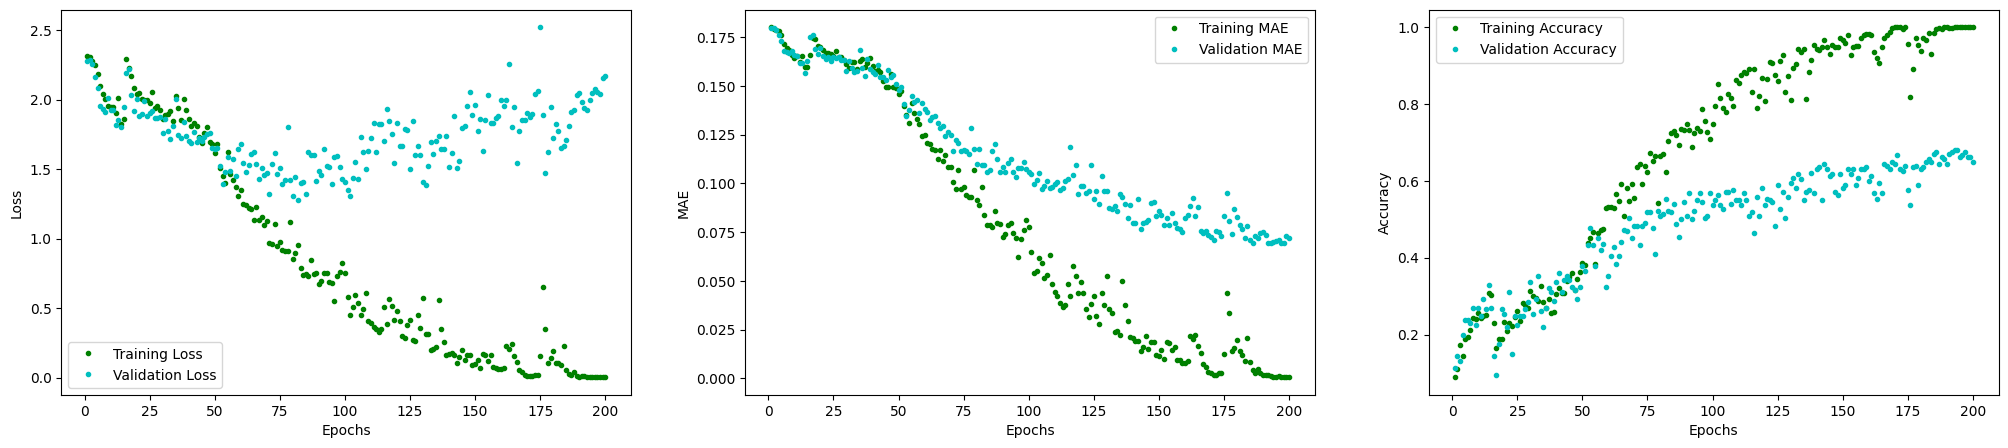

In [12]:
plot_history(lstm_stateful_history)

In [13]:
score = model_lstm_stateful.evaluate(x_test_normalized, y_test, verbose=0)
print("Test loss:", score[0])
print("Test accuracy:", score[1])

Test loss: 2.171837091445923
Test accuracy: 0.6486486196517944


In [ ]:
# KFold
# K-Fold validation
model = build_lstm_stateful_model(128, 128, False)

(acc_per_fold, loss_per_fold, confusion_per_fold) = kfold_cross_validation(model, combined_x, combined_y, num_folds=5)

In [17]:
print(acc_per_fold)
print("Acc: %.3f std: %.3f" % (np.average(acc_per_fold), np.std(acc_per_fold)))
print(np.average(loss_per_fold))

[75.73529481887817, 83.08823704719543, 79.41176295280457, 83.82353186607361, 71.32353186607361]
Acc: 78.676 std: 4.674
1.300222897529602


7/7 [==============================] - 0s 16ms/step


DEBUG:matplotlib.colorbar:locator: <matplotlib.ticker.AutoLocator object at 0x7f3b0c0f4fd0>


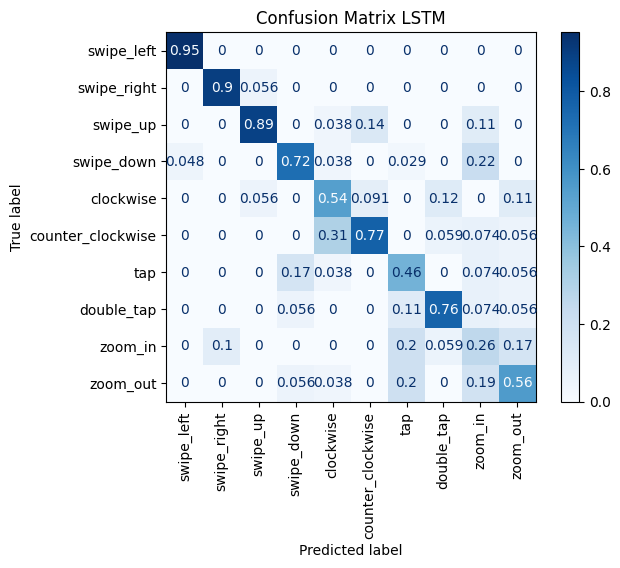

In [94]:
y_pred = model_lstm_stateful.predict(x_test_normalized)
ConfusionMatrixDisplay.from_predictions(np.argmax(y_test, axis=1), np.argmax(y_pred, axis=1), normalize='pred', cmap='Blues', display_labels=Gestures, xticks_rotation='vertical')

plt.title("Confusion Matrix LSTM")
plt.savefig('output_figures/confusion_matrix_lstm.svg', bbox_inches="tight")

plt.show()

DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 41 1216


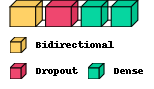

In [20]:
visualkeras.layered_view(model_lstm_stateful, legend=True).show()

49


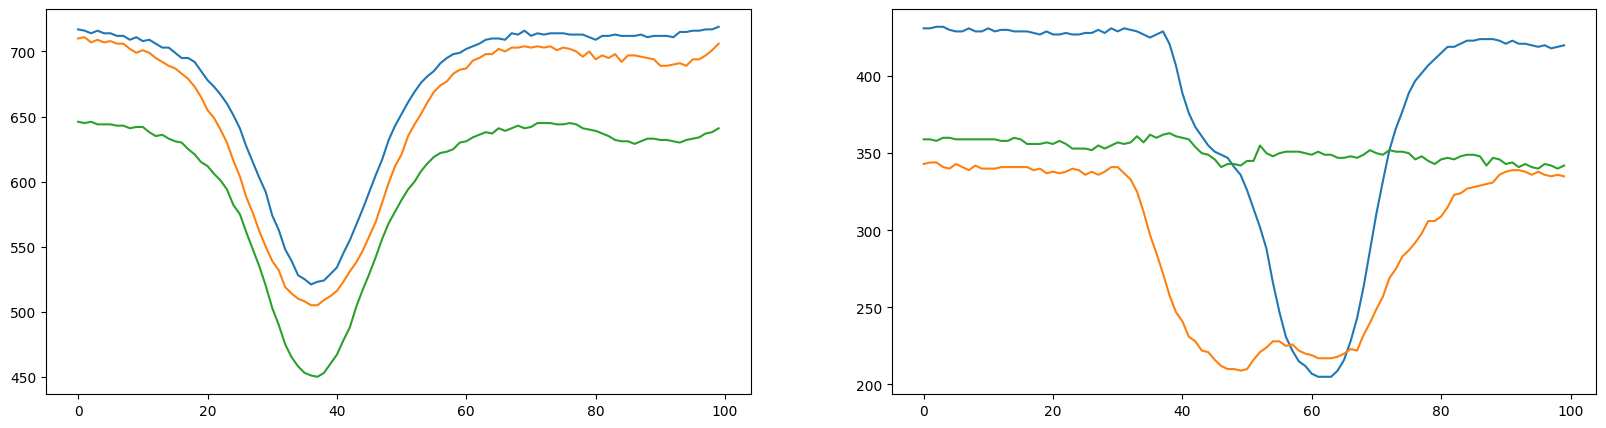

In [191]:
# taps = list(filter(lambda x: Gestures(x[1]) == Gestures.TAP, zip(x_train_normalized, y_train)))
# TODO: Remove the tap gesture that is noise
taps = load_gesture_samples(Gestures.TAP, Hand.right)
zooms = load_gesture_samples(Gestures.ZOOM_OUT, Hand.right)
print(len(taps))
random_tap = random.choice(taps)
random_zoom = random.choice(zooms)
# print(random_plot['candidate'])
fig, axs = plt.subplots(1, 2, figsize=(20, 5))
axs[0].plot(random_tap['data'])
axs[1].plot(random_zoom['data'])
plt.show()

Randomly selected gesture: 37


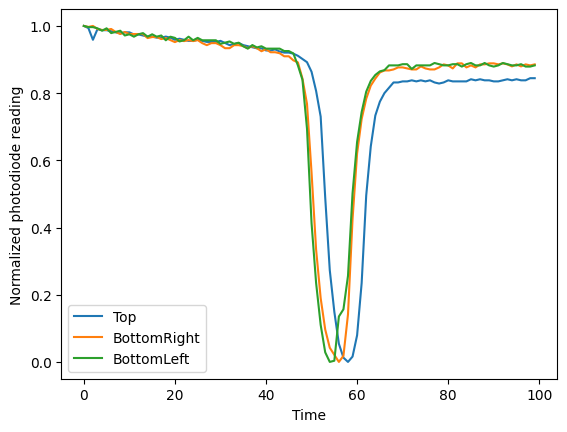

In [86]:
swipe_ups = load_gesture_samples(Gestures.SWIPE_UP, Hand.right)
random_select = random.randint(0, len(swipe_ups))
print("Randomly selected gesture: %d" % random_select)
selected_swipe_up = swipe_ups[14]['data']
scaler = MinMaxScaler((0, 1))
normalized_selected = scaler.fit_transform(selected_swipe_up)

plt.plot(normalized_selected)
plt.xlabel("Time")
plt.ylabel("Normalized photodiode reading")
plt.legend(['Top', 'BottomRight', 'BottomLeft'])
plt.savefig('output_figures/sample_graph.svg')
plt.show()

In [114]:
print("\n\n================= Running on testing data: =================")
y_pred = model_lstm_stateful.predict(x_test_normalized)
for actual, pred in zip(y_test, y_pred):
    pred = Gestures(np.argmax(pred))
    actual = Gestures(np.argmax(actual))
    if pred == Gestures.SWIPE_RIGHT:
        print("Prediction: %s, actual: %s" % (pred, actual))



================= Running on testing data: =================
7/7 [==============================] - 0s 16ms/step
Prediction: Gestures.SWIPE_RIGHT, actual: Gestures.SWIPE_RIGHT
Prediction: Gestures.SWIPE_RIGHT, actual: Gestures.SWIPE_RIGHT
Prediction: Gestures.SWIPE_RIGHT, actual: Gestures.SWIPE_RIGHT
Prediction: Gestures.SWIPE_RIGHT, actual: Gestures.SWIPE_RIGHT
Prediction: Gestures.SWIPE_RIGHT, actual: Gestures.SWIPE_RIGHT
Prediction: Gestures.SWIPE_RIGHT, actual: Gestures.SWIPE_RIGHT
Prediction: Gestures.SWIPE_RIGHT, actual: Gestures.SWIPE_RIGHT
Prediction: Gestures.SWIPE_RIGHT, actual: Gestures.SWIPE_RIGHT
Prediction: Gestures.SWIPE_RIGHT, actual: Gestures.SWIPE_RIGHT
Prediction: Gestures.SWIPE_RIGHT, actual: Gestures.SWIPE_UP
Prediction: Gestures.SWIPE_RIGHT, actual: Gestures.SWIPE_RIGHT
Prediction: Gestures.SWIPE_RIGHT, actual: Gestures.SWIPE_UP
Prediction: Gestures.SWIPE_RIGHT, actual: Gestures.SWIPE_RIGHT
Prediction: Gestures.SWIPE_RIGHT, actual: Gestures.SWIPE_RIGHT
Predictio